#3.2 Tutorial: KNN-Shapley & Gaussian Conditional Imputer

Demonstration der implementierten Funktionalitäten:
- Unweighted KNN-Shapley Explainer  
- Gaussian Conditional Imputer

Gruppe D - SEP ALML SoSe 2025
Implementiert von: [Yifan Yang]
Matrikelnummer: 12377282


In [ ]:
print("=== KNN-Shapley & Gaussian Imputer Tutorial ===")
print("Gruppe D - Softwareentwicklungspraktikum")

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

=== KNN-Shapley & Gaussian Imputer Tutorial ===
Gruppe D - Softwareentwicklungspraktikum


# Data preparation

## Why are these steps needed?
- **Generate data**: create a simple dataset
- **Train/Test Segmentation**: simulate a real machine learning workflow
- **Normalize**: KNN algorithm is based on distance calculation and requires features to be on the same scale!

## Data features
- 4 features (for easy understanding and visualization)
- 2 categories (binary classification problem)
- 200 samples (enough for training, but not too complex)

In [ ]:

# creat classification
X, y = make_classification(
    n_samples=200,
    n_features=4,
    n_classes=2,
    random_state=42,
    class_sep=1.5
)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"trainning data: {X_train_scaled.shape}")
print(f"test data: {X_test_scaled.shape}")
print(f"features: {X.shape[1]}")
print(f"lables: {np.unique(y)}")


trainning data: (140, 4)
test data: (60, 4)
features: 4
lables: [0 1]


# KNN model training

Now we train a KNN classifier, which will be the target model for our interpretation.

## KNN model features
- **Number of neighbors k=5**: as a demonstration
- **Distance based**: uses Euclidean distance to find nearest neighbors

In [ ]:


# create and fit model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# test performance
train_accuracy = knn_model.score(X_train_scaled, y_train)
test_accuracy = knn_model.score(X_test_scaled, y_test)

print(f"train accuracy: {train_accuracy:.3f}")
print(f"test accuracy: {test_accuracy:.3f}")

# choose a sample to explain
test_sample_idx = 0
x_explain = X_test_scaled[test_sample_idx]
true_label = y_test[test_sample_idx]
predicted_label = knn_model.predict(x_explain.reshape(1, -1))[0]

print(f"\nsample:")
print(f"true lable: {true_label}")
print(f"predicted label: {predicted_label}")
print(f"features: {x_explain.round(3)}")


train accuracy: 0.950
test accuracy: 0.983

sample:
true lable: 1
predicted label: 1
features: [ 0.408  0.72   0.322 -0.523]


# Import our implementation of the KNN-Shapley function

Now we import our own implementation of the KNNShapley interpreter to analyze model predictions.

## Our implementation of KNN-Shapley
- **KNNExplainer**: unified interpreter interface
- **KNNShapley**: the core unweighted KNN-Shapley algorithm
- **Function**: Calculate the contribution of each training sample to the prediction.

## Expected results
- Each training sample receives a Shapley value.
- Positive values indicate training samples that support the current prediction.
- Negative values indicate training samples that oppose the current prediction.

In [ ]:
import sys
sys.path.append('/content/SEP_ALML_GroupD')
!pip install shapiq overrides
import shapiq

from shapiq_student.knn_explainer import KNNExplainer
from shapiq_student.knn_shapley import KNNShapley

print("✓ KNN-Shapley modules imported!")
print(f"KNNExplainer类: {KNNExplainer}")
print(f"KNNShapley类: {KNNShapley}")




✓ KNN-Shapley modules imported!
KNNExplainer类: <class 'shapiq_student.knn_explainer.KNNExplainer'>
KNNShapley类: <class 'shapiq_student.knn_shapley.KNNShapley'>


## Interpreter settings
- **model**: the KNN classifier we trained on
- **data**: training data (used to compute Shapley values)
- **labels**: training labels
- **class_index**: the class we want to interpret (1)

In [ ]:
# create knn interpreter
print("create knn interpreter...")

try:
    # init
    knn_explainer = KNNExplainer(
        model=knn_model,
        data=X_train_scaled,
        labels=y_train,
        class_index=1,
        random_state=42
    )

    print(f"traing data shape: {X_train_scaled.shape}")
    print(f"training labels shape: {y_train.shape}")
    print(f"class_index: 1")

except Exception as e:
    print(f" error when creating explainer: {e}")


create knn explainer...
traing data shape: (140, 4)
training labels shape: (140,)
class_index: 1


# Calculate the KNN-Shapley value

Now we use the interpreter to compute the Shapley values for the samples we have chosen to test.

## Review of samples to be interpreted
- **True Label**: 1
- **Predictive label**: 1 ✓
- **Eigenvalue**: [0.408, 0.72, 0.322, -0.523]

## Shapley value meaning
- Each training sample will get a Shapley value
- **Positive**: The training sample supports the prediction of category 1.
- **Negative value**: the training sample is against the prediction of category 1
- The larger the **value**: the more important the effect is.

In [ ]:

print(f"explain eigenvalue: {x_explain.round(3)}")
print(f"true labels: {true_label}, predict labels: {predicted_label}")

try:
    # create instance of knnshapley
    knn_shapley = KNNShapley(
        model=knn_model,
        data=X_train_scaled,
        labels=y_train,
        class_index=1
    )


    # compute shapley value
    shapley_values = knn_shapley.knn_shapley(x_explain.reshape(1, -1))

    print(f"num of Shapley values: {len(shapley_values)}")
    print(f"num of trainging data: {len(y_train)}")


    # find biggest positive value
    top_positive_idx = np.argmax(shapley_values)
    top_positive_value = shapley_values[top_positive_idx]

    # find biggest negative value
    top_negative_idx = np.argmin(shapley_values)
    top_negative_value = shapley_values[top_negative_idx]

    print(f"best supported sample #{top_positive_idx}:")
    print(f"  Shapley: {top_positive_value:.4f}")
    print(f"  label: {y_train[top_positive_idx]}")

    print(f"\nmost againsted sample #{top_negative_idx}:")
    print(f"  Shapley value: {top_negative_value:.4f}")
    print(f"  label: {y_train[top_negative_idx]}")

    positive_contrib = np.sum(shapley_values[shapley_values > 0])
    negative_contrib = np.sum(shapley_values[shapley_values < 0])

    print(f"\n=== overall contribution ===")
    print(f"sum of positive contribution: {positive_contrib:.4f}")
    print(f"sum of negative contribution: {negative_contrib:.4f}")
    print(f"net contribution: {positive_contrib + negative_contrib:.4f}")

except Exception as e:
    print(f"❌ error in computing: {e}")
    import traceback
    traceback.print_exc()


explain eigenvalue: [ 0.408  0.72   0.322 -0.523]
true labels: 1, predict labels: 1
num of Shapley values: 140
num of trainging data: 140
best supported sample #1:
  Shapley: 0.0459
  label: 1

most againsted sample #26:
  Shapley value: -0.1541
  label: 0

=== overall contribution ===
sum of positive contribution: 1.2552
sum of negative contribution: -0.6552
net contribution: 0.6000


# Visualize the KNN-Shapley results

Now that we have calculated the Shapley values, let's visualize the results to better understand them.

## Visualize the content
1. **Histogram of the distribution of Shapley values** - see the overall distribution of contributions
2. **Top Contributions training samples** - the most important positive and negative contributions

This will help us understand how the KNN model makes predictive decisions.


=== conclusion ===
sum of samples: 140
samples with positive contribution: 72
samples with negative contribution: 68
avg Shapley value: 0.0043
standard error for shapley value: 0.0249


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 37322 (\N{CJK UNIFIED IDEOGRAPH-91CA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtool

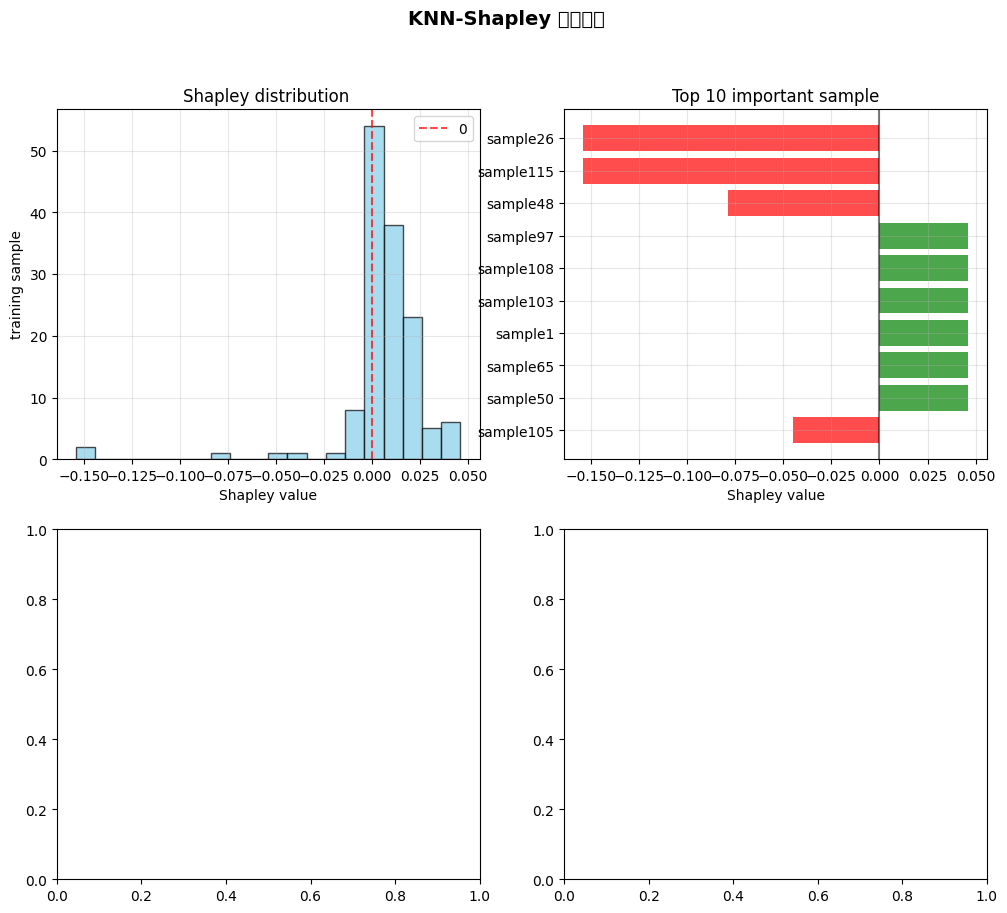

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('KNN-Shapley 解释结果', fontsize=14, fontweight='bold')

# 1: Shapley value histop gramm
axes[0, 0].hist(shapley_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7, label='0')
axes[0, 0].set_xlabel('Shapley value')
axes[0, 0].set_ylabel('training sample')
axes[0, 0].set_title('Shapley distribution ')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2: Top 10 important contributions
top_indices = np.argsort(np.abs(shapley_values))[-10:]  # biggest abs value
top_values = shapley_values[top_indices]
colors = ['green' if v > 0 else 'red' for v in top_values]

axes[0, 1].barh(range(len(top_values)), top_values, color=colors, alpha=0.7)
axes[0, 1].set_yticks(range(len(top_values)))
axes[0, 1].set_yticklabels([f'sample{i}' for i in top_indices])
axes[0, 1].set_xlabel('Shapley value')
axes[0, 1].set_title('Top 10 important sample')
axes[0, 1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

print(f"\n=== conclusion ===")
print(f"sum of samples: {len(shapley_values)}")
print(f"samples with positive contribution: {np.sum(shapley_values > 0)}")
print(f"samples with negative contribution: {np.sum(shapley_values < 0)}")
print(f"avg Shapley value: {np.mean(shapley_values):.4f}")
print(f"standard error for shapley value: {np.std(shapley_values):.4f}")


# Gaussian Conditional Imputer Demo

Now we demonstrate the second core function you have implemented: Gaussian Conditional Imputer.

## Function Description
- **Purpose**: Conditional data padding based on multivariate Gaussian distribution
- **Benefits**: Consider correlation between features, smarter than simple mean/median padding.
- **Application**: Handle missing data, support shapiq framework

## Demonstration Plan
1. Create data with missing values
2. Use our GaussianImputer for padding.
3. Compare the results with other padding methods

In [ ]:

demo_samples = X_test_scaled[:5].copy()  # take first 5

# manuel create missing data
missing_patterns = [
    [1],           # 0: missing feature 1
    [0, 3],        # 1: 0 and 3
    [2],           # 2: 2
    [1, 2],        # 3: 1 and 2
    []             # 4:
]

demo_with_missing = demo_samples.copy()
for sample_idx, missing_features in enumerate(missing_patterns):
    if missing_features:
        demo_with_missing[sample_idx, missing_features] = np.nan

for i, pattern in enumerate(missing_patterns):
    if pattern:
        print(f"sample {i}: feature {pattern} as missing")
    else:
        print(f"sample {i}: no missing as comparision）")


for i in range(len(demo_samples)):
    original = demo_samples[i]
    with_missing = demo_with_missing[i]
    missing_count = np.sum(np.isnan(with_missing))
    missing_positions = np.where(np.isnan(with_missing))[0]

    print(f"\n sample {i}:")
    print(f"  raw value: {original.round(3)}")
    print(f"  after missing: {with_missing}")
    print(f"  missed features: {missing_positions} ({missing_count})")






sample 0: feature [1] as missing
sample 1: feature [0, 3] as missing
sample 2: feature [2] as missing
sample 3: feature [1, 2] as missing
sample 4: no missing as comparision）

 sample 0:
  raw value: [ 0.408  0.72   0.322 -0.523]
  after missing: [ 0.40793392         nan  0.32235503 -0.52321122]
  missed features: [1] (1)

 sample 1:
  raw value: [-0.113  1.562  1.356 -1.538]
  after missing: [       nan 1.56162402 1.35593522        nan]
  missed features: [0 3] (2)

 sample 2:
  raw value: [ 0.983 -0.591 -1.132  0.962]
  after missing: [ 0.98289095 -0.59098367         nan  0.9615105 ]
  missed features: [2] (1)

 sample 3:
  raw value: [ 0.747  0.384 -0.177 -0.065]
  after missing: [ 0.74748816         nan         nan -0.06534363]
  missed features: [1 2] (2)

 sample 4:
  raw value: [-0.085 -1.347 -1.049  1.252]
  after missing: [-0.08488804 -1.34671055 -1.04912721  1.25241325]
  missed features: [] (0)


# Using the Gaussian Conditional Imputer

Now we use your implementation of GaussianImputer to handle missing data.

## Imputer works
1. **Fitting**: learns a multivariate Gaussian distribution for the complete training data
2. **Conditional Distribution**: Calculate the conditional expectation of missing features based on the observed features.
3. **Filling**: Fill the missing positions with the conditional expectation.

In [ ]:

try:
    from shapiq_student.imputer import GaussianImputer
    print("✓ GaussianImputer imported!")
except ImportError as e:
    print(f" import error: {e}")

from sklearn.ensemble import RandomForestClassifier
demo_model = RandomForestClassifier(n_estimators=30, random_state=42)
demo_model.fit(X_train_scaled, y_train)

imputation_results = []

print(f"\n{'='*60}")
print("performance:")
print(f"{'='*60}")

for sample_idx in range(len(demo_samples)):
    original = demo_samples[sample_idx]
    with_missing = demo_with_missing[sample_idx]
    missing_positions = np.where(np.isnan(with_missing))[0]

    if len(missing_positions) == 0:
        print(f"\n--- sample {sample_idx}: has no missing, skip---")
        continue

    print(f"\n--- sample {sample_idx}: {len(missing_positions)} missed features ---")
    print(f"missed feature: {missing_positions}")
    print(f"raw value: {original.round(3)}")
    print(f"after missing: {with_missing}")

    try:
        # create gaussian imputer
        gaussian_imputer = GaussianImputer(
            model=demo_model.predict,
            data=X_train_scaled,
            x=with_missing
        )

        # fit and fill
        gaussian_imputer.fit(with_missing)
        sample_mask = np.isnan(with_missing).reshape(1, -1)
        imputed = gaussian_imputer.transform(
            with_missing.reshape(1, -1),
            mask=sample_mask
        )[0]

        print(f"after filling: {imputed.round(3)}")

        # compute error in fill
        errors = []
        for pos in missing_positions:
            original_val = original[pos]
            imputed_val = imputed[pos]
            error = abs(original_val - imputed_val)
            errors.append(error)
            print(f"  feature{pos}: {original_val:6.3f} → {imputed_val:6.3f} (error: {error:.3f})")

        # results
        mae = np.mean(errors)
        result = {
            'sample_idx': sample_idx,
            'n_missing': len(missing_positions),
            'missing_features': missing_positions.tolist(),
            'mae': mae,
            'errors': errors
        }
        imputation_results.append(result)

        print(f"avg abs error: {mae:.3f}")


    except Exception as e:
        print(f" sample{sample_idx}fail filling: {e}")

# conclusion
if imputation_results:
    print(f"\n{'='*60}")
    print("overall results")
    print(f"{'='*60}")

    all_maes = [result['mae'] for result in imputation_results]
    print(f"avg MAE: {np.mean(all_maes):.3f}")
    print(f"MAE std: {np.std(all_maes):.3f}")


✓ GaussianImputer imported!

performance:

--- sample 0: 1 missed features ---
missed feature: [1]
raw value: [ 0.408  0.72   0.322 -0.523]
after missing: [ 0.40793392         nan  0.32235503 -0.52321122]
after filling: [ 0.408  0.     0.322 -0.523]
  feature1:  0.720 →  0.000 (error: 0.720)
avg abs error: 0.720

--- sample 1: 2 missed features ---
missed feature: [0 3]
raw value: [-0.113  1.562  1.356 -1.538]
after missing: [       nan 1.56162402 1.35593522        nan]
after filling: [-0.113  1.562  1.356 -1.538]
  feature0: -0.113 → -0.113 (error: 0.000)
  feature3: -1.538 → -1.538 (error: 0.000)
avg abs error: 0.000

--- sample 2: 1 missed features ---
missed feature: [2]
raw value: [ 0.983 -0.591 -1.132  0.962]
after missing: [ 0.98289095 -0.59098367         nan  0.9615105 ]
after filling: [ 0.983 -0.591  0.     0.962]
  feature2: -1.132 →  0.000 (error: 1.132)
avg abs error: 1.132

--- sample 3: 2 missed features ---
missed feature: [1 2]
raw value: [ 0.747  0.384 -0.177 -0.065]
a

To summarize: when the sample size is small or the missingness rate is high, the covariance estimates are unstable and may introduce additional noise